# Car Depreciation Analysis
### Peter Crawford (July - 2020)

Load packages

In [306]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as statsMods
import statsmodels.api as sm
import statistics
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import requests
from bs4 import BeautifulSoup # package to scrape data
from colorama import Fore, Style

## Scrape data from Cars.com
Scraping can get a little complicated,you can inspect a webpage in your browser by right clicking and selecting "inspect." If you have had very little exposure to html code, then search for the pattern that aligns with the data you are trying to collect. 

This chunk of code uses a for loop as there are ~44 different pages to scrape from.

In [272]:
mileage = []
price = []
title = []
extra = []
for i in range(1,44):
    URL = 'https://www.cars.com/for-sale/searchresults.action/?mdId=22265&mkId=20089&page=' + str(i) + '&perPage=100&rd=99999&searchSource=PAGINATION&sort=relevance&stkTypId=28881&zc=84601'
    page = requests.get(URL)
    soup = BeautifulSoup(page.content, 'html.parser')
    cars = soup.find_all('div', attrs = {'class':'shop-srp-listings__listing-container'})
    for car in cars:
        mileage.append(car.find('span', class_='listing-row__mileage').text)
        price.append(car.find('span', class_='listing-row__price').text)
        title.append(car.find('h2', class_='listing-row__title').text)
        extra.append(car.find('ul', class_='listing-row__meta').text)

In [30]:
# After figuring out a way to read in multiple pages of data, I no longer use this code
# and have commented it out as it only reads in one page at a time.
# URL = 'https://www.cars.com/for-sale/searchresults.action/?mdId=22265&mkId=20089&page=1&perPage=100&rd=99999&searchSource=PAGINATION&sort=relevance&stkTypId=28881&zc=84601'
# page = requests.get(URL)
# soup = BeautifulSoup(page.content, 'html.parser')
# cars = soup.find_all('div', attrs = {'class':'shop-srp-listings__listing-container'})
# print(cars)

Parse through HTML to create python objects

In [41]:
# mileage = []
# price = []                     # this section can get finicky if you don't have it set to "Used"
# title = []
# extra = []
# for car in cars:
#     mileage.append(car.find('span', class_='listing-row__mileage').text)
#     price.append(car.find('span', class_='listing-row__price').text)
#     title.append(car.find('h2', class_='listing-row__title').text)
#     extra.append(car.find('ul', class_='listing-row__meta').text)

In [273]:
list_of_cars = list(zip(mileage, price, title, extra))
df = pd.DataFrame(list_of_cars, columns = ['mileage', 'price', 'title', 'extra'])  

First row of variables:

In [274]:
print(mileage[0].strip(), '\n', 
      price[0].strip(), '\n',
      title[0].strip(), '\n',
      extra[0].split()[0:9])

5,764 mi. 
 $25,313 
 2019 Volkswagen Tiguan 2.0T SE 
 ['Ext.', 'Color:', 'Gray', 'Int.', 'Color:', 'Black', 'Transmission:', 'Automatic', 'Drivetrain:']


This next chunk of code to create more variables out of the 'extra' list and clean up the price/mileage strings to be recognized as integers.

In [275]:
year = []
make = []
model = []
type1 = []
type2 = []
extColor = []
intColor = []
transmission = []
drivetrain = []
for col in df.columns:
    if col == "title":
        for a in range(0,len(df)):                     # Parse the "title" column to add more features
            year.append(df[col][a].split()[0])
            make.append(df[col][a].split()[1])
            model.append(df[col][a].split()[2])
            if len(df[col][a].split()) == 4:
                type1.append(df[col][a].split()[3])
            else:
                type1.append('NA')
            if len(df[col][a].split()) == 5:
                type2.append(df[col][a].split()[4])
            else:
                type2.append('NA')
    elif col == "extra":                               # Parse the "extra" column to add more features
        for a in range(0, len(df)):
            extColor.append(df[col][a].split()[2])
            intColor.append(df[col][a].split()[5])
            transmission.append(df[col][a].split()[7])
            drivetrain.append(df[col][a].split()[9])                
    else:                                              # Edit the mileage and price so they can be changed to numeric
        for a in range(0,len(df)):
            df[col][a] = df[col][a].split()[0]
            df[col][a] = df[col][a].replace(",", "")
            df[col][a] = df[col][a].replace("$", "")
            df[col][a] = df[col][a].replace("Not", "0")
            df[col][a] = df[col][a].replace("--", "0")

Add the created variables (from lists) as new columns to the df.

In [276]:
df['year'] = year
df['make'] = make
df['model'] = model
df['type1'] = type1
df['type2'] = type2
df = df.drop(columns = ['title'])
df['extColor'] = extColor
df['intColor'] = intColor
df['transmission'] = transmission
df['drivetrain'] = drivetrain
df = df.drop(columns = ['extra'])

In [277]:
df['mileage'] = df['mileage'].astype(float)
df['price'] = df['price'].astype(float)
df['year'] = df['year'].astype(int)

Drop observations in which milieage or price is excluded (maybe in the future try interpolating).   
Drop observations with mileage over 200,000.

In [278]:
df = df[df.mileage != 0]
df = df[df.price != 0]

In [279]:
df = df[df.mileage < 200000]

In [280]:
df['type'] = df['type1'] + df['type2']
df = df.drop(columns = ['type1', 'type2'])
df['type'] = df['type'].str.replace('NA','')
df['type'] = df['type'].str.replace("MOTION", "Motion")

## Plot Data:   
Interaction between quantitiative variables mileage, year, and price.

Text(46.516464, 0.5, 'Price')

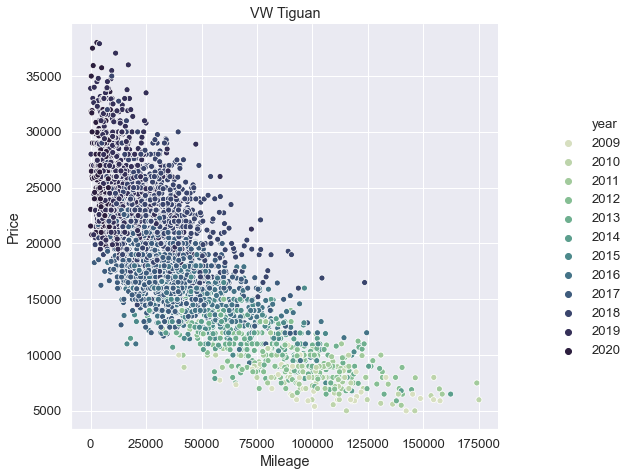

In [281]:
sns.set(font_scale = 1.2)
custPalette = sns.cubehelix_palette(12, start=.5, rot=-.75)
sns.relplot(x="mileage", y="price", hue = "year", data = df, palette = custPalette).fig.set_size_inches(10,7)
plt.title("VW Tiguan")
plt.xlabel("Mileage")
plt.ylabel("Price")

Using the following count plots we can see which Categorical variables we can combine to "Other."   
The subsequent chunks of code filter out specified values that don't have very many observations.

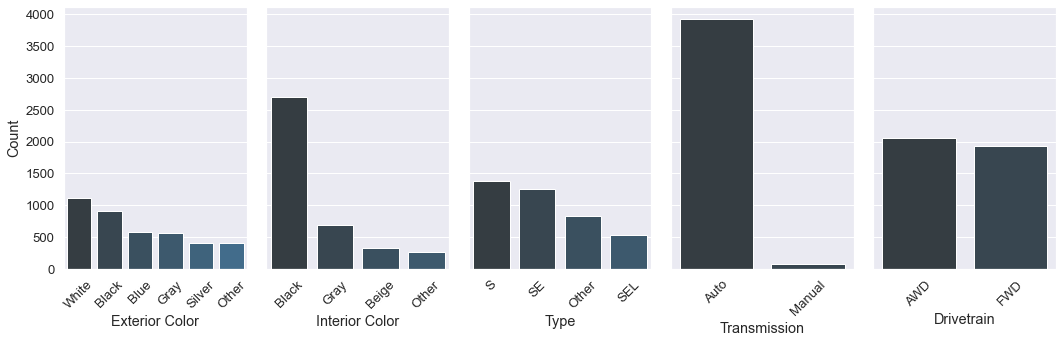

In [292]:
#sns.set(font_scale = 1.4)
f, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(1, 5, figsize=(15, 5), sharey = True)
sns.set_palette(sns.color_palette("Blues_d", n_colors = 16))

# Interior color
sns.countplot(x = 'extColor', data = df, ax = ax1, order = df['extColor'].value_counts().index)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set(xlabel = 'Exterior Color')
ax1.set(ylabel = 'Count')

# Exterior color
sns.countplot(x = 'intColor', data = df, ax = ax2, order = df['intColor'].value_counts().index)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set(xlabel = 'Interior Color')
ax2.set(ylabel = None)

# Type
sns.countplot(x = 'type', data = df, ax = ax3, order = df['type'].value_counts().index)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
ax3.set(xlabel = 'Type')
ax3.set(ylabel = None)

# Transmission
sns.countplot(x = 'transmission', data = df, ax = ax4)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
ax4.set(xlabel = 'Transmission')
ax4.set(ylabel = None)

# Drivetrain
sns.countplot(x = 'drivetrain', data = df, ax = ax5)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
ax5.set(xlabel = 'Drivetrain')
ax5.set(ylabel = None)

plt.tight_layout()
plt.savefig("qual_vars2.png", dpi=300)

In [283]:
df = df.replace({'extColor': {'Red':'Other',
                              'Green':'Other',
                              'Orange':'Other',
                              'Gold':'Other',
                              'Brown':'Other',
                              'Beige':'Other',
                              'Purple':'Other'}})

In [285]:
df = df.replace({'intColor': {'White':'Other',
                              'Orange':'Other',
                              'Gold':'Other',
                              'Brown':'Other',
                              'Blue':'Other',
                              'Silver':'Other'}})

In [289]:
df = df.replace({'transmission': {'Automanual':'Manual',
                                  'Other':'Manual',
                                  'Automatic':'Auto'}})

In [291]:
df = df.replace({'drivetrain': {'4x4/4-wheel':'AWD',
                                '4x2/2-wheel':'FWD',
                                'RWD':'FWD',
                                'Unknown':'AWD'}})

In [287]:
df = df.replace({'type': {'2.0T':'Other',
                          '4-DR':'Other',
                          '4Motion':'Other',
                          '4WD':'Other',
                          'AWD':'Other',
                          'Edition':'Other',
                          'LE':'Other',
                          'Limited':'Other',
                          'Premium':'Other',
                          'R-Line':'Other',
                          'RADIO':'Other',
                          'Sport':'Other',
                          'TURBOCHARGED-I4':'Other',
                          'Wolfsburg':'Other',
                          '':'Other'}})

# set(list(df['drivetrain'])) # Code to make sure that values were changed

Boxplot to see the interaction between price and categorical variables.

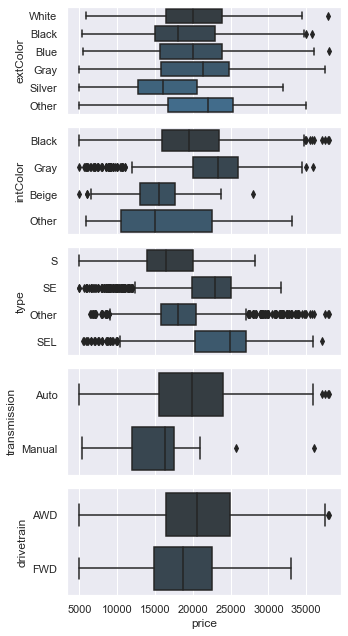

In [293]:
sns.set(font_scale = 1)
f, [ax1, ax2, ax3, ax4, ax5] = plt.subplots(5, 1, figsize=(5, 9), sharex = True)
sns.set_palette(sns.color_palette("Blues_d", n_colors = 16))

# Interior color
sns.boxplot(y = df['extColor'], x = df['price'], ax = ax1, order = df['extColor'].value_counts().index)
ax1.set(xlabel = None)

# Exterior color
sns.boxplot(y = df['intColor'], x = df['price'], ax = ax2, order = df['intColor'].value_counts().index)
ax2.set(xlabel = None)

# Type
sns.boxplot(y = df['type'], x = df['price'], ax = ax3, order = df['type'].value_counts().index)
ax3.set(xlabel = None)

# Transmission
sns.boxplot(y = df['transmission'], x = df['price'], ax = ax4)
ax4.set(xlabel = None)

# Drivetrain
sns.boxplot(y = df['drivetrain'], x = df['price'], ax = ax5)

plt.tight_layout()
plt.savefig("qual_vars1.png", dpi=300)

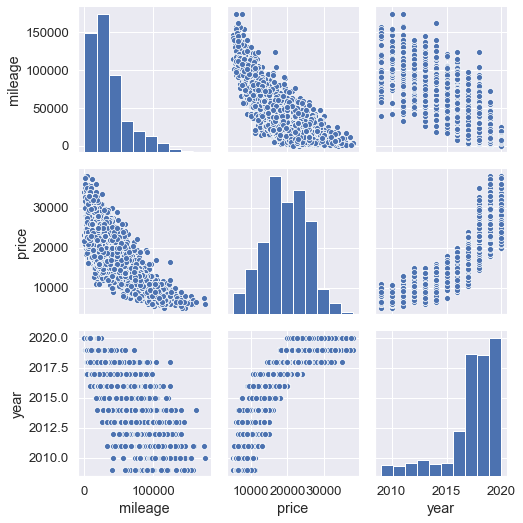

In [294]:
sns.set(font_scale = 1.2)
sns.pairplot(df)#, diag_kind = "kde", corner = False)#, hue = 'drivetrain')
plt.tight_layout()
plt.savefig("quant_vars.png", dpi=300)

In [295]:
print('Price average: ', round(np.average(df['price']),3))
print('Mileage average: ', round(np.average(df['mileage']),2))
print('Year average: ', round(np.average(df['year']),2))

Price average:  19472.446
Mileage average:  35451.44
Year average:  2017.1


## Create models:

Create train and test

In [297]:
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(df['mileage'], df['price'], test_size = 0.2, random_state = 0)

### Simple Linear Regression:

In [298]:
SLR_model = LinearRegression()
miles = X_train1.to_numpy()
SLR_model.fit(miles.reshape(-1,1), Y_train1)
print('intercept:', SLR_model.intercept_)
print('slope:', SLR_model.coef_)

intercept: 25169.050702935067
slope: [-0.16194375]


In [299]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color = 'red')

Text(0, 0.5, 'Price')

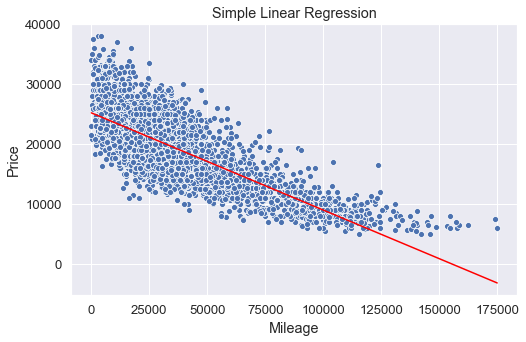

In [300]:
figure(figsize=(8, 5))
model_pred = SLR_model.predict(miles.reshape(-1,1))
sns.scatterplot(df['mileage'], df['price'])
sns.lineplot(miles, model_pred, color = "red")
plt.title("Simple Linear Regression")
plt.xlabel("Mileage")
plt.ylabel("Price")

Take a look into residuals.

In [313]:
miles_test = X_test1.to_numpy()
resids = pd.DataFrame(Y_test1 - SLR_model.predict(miles_test.reshape(-1,1)))
resids['mileage'] = X_test1

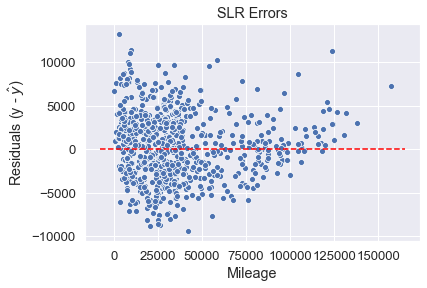

In [314]:
ax = sns.scatterplot(resids['mileage'], resids['price'])
ax.set(title = 'SLR Errors')
ax.set(xlabel = 'Mileage')
ax.set(ylabel = 'Residuals (y - $\hat{y}$)')
abline(0,0)

Get a summary: R2, coefficient, p-value.

In [305]:
est = sm.OLS(df['price'], sm.add_constant(df['mileage'])).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     6066.
Date:                Wed, 12 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:40:55   Log-Likelihood:                -38471.
No. Observations:                3992   AIC:                         7.695e+04
Df Residuals:                    3990   BIC:                         7.696e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.523e+04     94.387    267.297      0.0

### Polynomial regression:

Text(0, 0.5, 'Price')

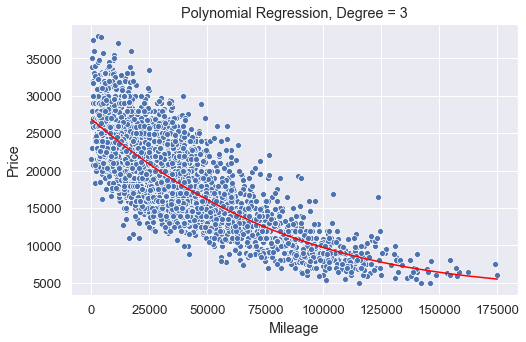

In [307]:
figure(figsize=(8, 5))
mymodel = np.poly1d(np.polyfit(X_train1, Y_train1, 3)) # change the degree here
myline = np.linspace(np.min(X_train1), np.max(X_train1), len(df))
sns.scatterplot(df['mileage'], df['price'])
sns.lineplot(X_train1, mymodel(X_train1), color = 'red')
plt.title("Polynomial Regression, Degree = 3")
plt.xlabel("Mileage")
plt.ylabel("Price")

In [308]:
print(mymodel(0) - mymodel(25000))
print(mymodel(25000) - mymodel(50000))
print(mymodel(50000) - mymodel(75000))
print(mymodel(75000) - mymodel(100000))

6012.522496938309
4752.356692790372
3656.1752414092316
2723.9781427948838


In [309]:
resids2 = pd.DataFrame(Y_test1 - mymodel(X_test1))
resids2['mileage'] = X_test1

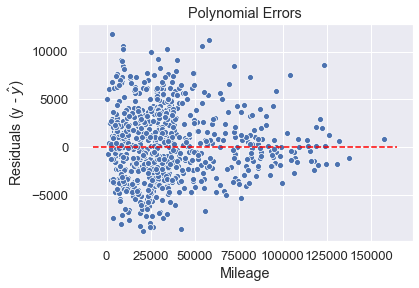

In [310]:
ax = sns.scatterplot(resids2['mileage'], resids2['price'])
ax.set(title = 'Polynomial Errors')
ax.set(xlabel = 'Mileage')
ax.set(ylabel = 'Residuals (y - $\hat{y}$)')
abline(0,0)

In [311]:
r2_score(Y_test1, mymodel(X_test1))

0.6149632497906063

#### Multiple regression with mileage, year, and price:

Create dummy variables from categorical variables.   
And create new train and test, with one hot encoded df.

In [397]:
df_dummy = pd.concat([pd.DataFrame(df[['mileage', 'year']]),
          pd.get_dummies(data=df['intColor'], prefix = "int"),
          pd.get_dummies(data = df['extColor'], prefix = "ext"),
          pd.get_dummies(data = df['type'], prefix = "type"), # merge the two "type" cols
          pd.get_dummies(data = df['transmission'], prefix = "trans"),
          pd.get_dummies(data = df['drivetrain'], prefix = "dt")], axis = 1)

In [398]:
df_dummy = df_dummy.drop(columns = ['int_Other', 'ext_Other', 'type_Other', 'trans_Manual', 'dt_FWD'])

In [399]:
X = df_dummy.iloc[:, df_dummy.columns != 'price']
Y = df.iloc[:, df.columns == 'price']
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [400]:
mlr = linear_model.LinearRegression()
mlr.fit(X_train2, Y_train2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [401]:
est = sm.OLS(endog = Y, exog = X).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          1.304e+04
Date:                Wed, 12 Aug 2020   Prob (F-statistic):                        0.00
Time:                        21:51:05   Log-Likelihood:                         -37451.
No. Observations:                3992   AIC:                                  7.493e+04
Df Residuals:                    3977   BIC:                                  7.503e+04
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [445]:
y_pred = pd.DataFrame(mlr.predict(X_test2)).set_index(Y_test2.index)
result = pd.concat([Y_test2, y_pred], axis = 1)
result.columns = ['Actual', 'Predicted']
result['Differences'] = result['Actual'] - result['Predicted']
result['Percent_Diff'] = abs((result['Actual'] - result['Predicted']) / result['Actual']) * 100

color = []
for index, value in result.Differences.items():
    if (value >= 0):
        color.append("Over-priced")
    else:
        color.append("Under-priced")
        
temp_list = list(zip(result['Differences'], color))
df5 = pd.DataFrame(temp_list, columns = ['diff', 'Value'])

## Predictions:   
Predict for a specific hypothetical car.

In [407]:
Xnew = [[50000, 2018, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]]

In [408]:
pred_price = mlr.predict(Xnew)
print("Predicted Price:", '\033[1m', "$", round(pd.DataFrame(pred_price)[0][0], 2))
print(Style.RESET_ALL)

Predicted Price:  $ 23277.12



Predict for Y_test and find the best deals (under-valued cars).

In [446]:
df5 = df5.iloc[0:25]
df5 = df5.sort_values(by=['diff'])

[Text(0.5, 1.0, 'Actual Car Price Minus Predicted')]

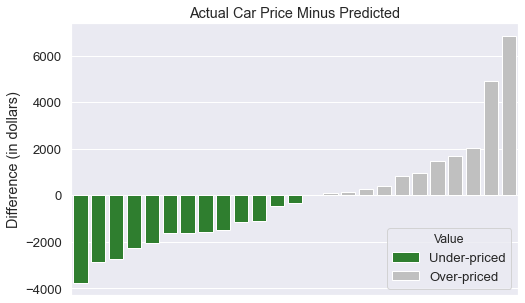

In [447]:
figure(figsize=(8, 5))
sns.set(font_scale = 1.2)
ax = sns.barplot(data = df5, x = np.linspace(0,24,25), y = 'diff', hue = 'Value', palette=["forestgreen", "silver"], dodge = False)
ax.set(xticklabels=[])
ax.set(ylabel = 'Difference (in dollars)')
ax.set(title = "Actual Car Price Minus Predicted")